# Fit sliding window of stock markets

In [12]:
import os
import os.path as osp
import numpy as np

In [27]:
import shutil

data_path_base = '../data/Bayesianneuralnet_stockmarket/code/datasets'
def reset_folder(path):
    if not osp.exists(temp_dir):
        os.makedirs(path)
    else:
        shutil.rmtree(path)
        os.makedirs(path)

for d in os.listdir("../data/Bayesianneuralnet_stockmarket/code/datasets/raw"):
    if osp.isfile(osp.join('../data/Bayesianneuralnet_stockmarket/code/datasets/raw', d)):
        name = osp.splitext(d)[0]
    data_path_base = '../data/Bayesianneuralnet_stockmarket/code/datasets/' + name

    timesteps = 5
    steps_ahead = 5

    data_min = 0
    data_max = 1

    with open(data_path_base + '_train.txt', 'r') as f:
        raw_data = f.readlines()
        data_min, data_max = list(map(lambda x: print(x), raw_data[0].split(' ')))
        train = list(map(lambda l: l.strip().split(' '), raw_data[1:]))
        train = np.asarray(train, np.float)

    with open(data_path_base + '_test.txt', 'r') as f:
        raw_data = f.readlines()
        data_min, data_max = list(map(lambda x: np.float(x), raw_data[0].split(' ')))
        test = list(map(lambda l: l.strip().split(' '), raw_data[1:]))
        test = np.asarray(test, np.float)

    if steps_ahead == 1:
        result_dir = 'one_step_results/' + name
        temp_dir = 'one_step_problemfolder/' + name + '/nns_temp'
    else:
        result_dir = 'results/' + name
        temp_dir = 'problemfolder/' + name + '/nns_temp'

    reset_folder(temp_dir)

    assert timesteps + steps_ahead <= train.shape[-1]
    train_x = train[:, :timesteps]
    train_y = train[:, timesteps: timesteps + steps_ahead]

    test_x = test[:, :timesteps]
    test_y = test[:, timesteps: timesteps + steps_ahead]

38.154682
70.451347

54.860165
80.417709





<ipython-input-27-0084bf63c028>:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train = np.asarray(train, np.float)
<ipython-input-27-0084bf63c028>:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_min, data_max = list(map(lambda x: np.float(x), raw_data[0].split(' ')))
<ipython-input-27-0084bf63c028>:32: DeprecationWarning: `np.fl

ValueError: not enough values to unpack (expected 2, got 1)

In [32]:
data_path_base = '../data/Bayesianneuralnet_stockmarket/code/datasets'

# horizon
timesteps = 5
steps_ahead = 5

# load
train = np.loadtxt(open(os.path.join(data_path_base, "MMM8_train.txt")))
train.shape

(804, 10)

In [33]:
train

array([[5.54000e-04, 3.73900e-03, 1.98500e-03, ..., 4.20000e-03,
        1.06200e-03, 3.97000e-03],
       [1.98500e-03, 0.00000e+00, 2.30800e-03, ..., 3.97000e-03,
        7.84700e-03, 1.12160e-02],
       [2.30800e-03, 4.29300e-03, 1.84600e-03, ..., 1.12160e-02,
        1.05240e-02, 1.03390e-02],
       ...,
       [6.93515e-01, 7.01704e-01, 6.94112e-01, ..., 6.94491e-01,
        6.76650e-01, 6.92593e-01],
       [6.94112e-01, 7.09296e-01, 6.94166e-01, ..., 6.92593e-01,
        6.84730e-01, 6.97528e-01],
       [6.94166e-01, 6.92539e-01, 6.96552e-01, ..., 6.97528e-01,
        7.05500e-01, 7.06259e-01]])

In [48]:
x_train = train[:, :timesteps]
y_train = train[:, timesteps: timesteps + steps_ahead]
xy_train = (x_train, y_train)

In [49]:
train_x.shape

(804, 5)

In [50]:
train_y.shape

(804, 5)

In [51]:
## BNN training
# %%
import numpy as np
np.random.seed(0)

import haiku as hk

import jax.numpy as jnp
import jax

from tqdm import tqdm, trange
from matplotlib import pyplot as plt

from jax_bayes.utils import confidence_bands
from jax_bayes.mcmc import (
	# langevin_fns,
	mala_fns,
	# hmc_fns,
)

#could use any of the samplers modulo hyperparameters
# sampler_fns = hmc_fns
# sampler_fns = langevin_fns
sampler_fns = mala_fns

def build_dataset():
	n_train, n_test, d = 200, 100, 1
	xlims = [-1.0, 5.0]
	x_train = np.random.rand(n_train, d) * (xlims[1] - xlims[0]) + xlims[0]
	x_test = np.random.rand(n_test, d) * (xlims[1] - xlims[0]) + xlims[0]

	target_func = lambda t: (np.log(t + 100.0) * np.sin(1.0 * np.pi*t)) + 0.1 * t

	y_train = target_func(x_train)
	y_test = target_func(x_test)

	y_train += np.random.randn(*x_train.shape) * (1.0 * (x_train + 2.0)**0.5)

	return (x_train, y_train), (x_test, y_test)

def net_fn(x):

	mlp = hk.Sequential([
		hk.Linear(128, w_init=hk.initializers.Constant(0), 
					   b_init=hk.initializers.Constant(0)), 
		jnp.tanh, 
		hk.Linear(1,   w_init=hk.initializers.Constant(0), 
					   b_init=hk.initializers.Constant(0))
		])

	return mlp(x)

In [52]:
lr = 1e-4
reg = 0.1
lik_var = 0.5

net = hk.transform(net_fn)
key = jax.random.PRNGKey(0)

sampler_init, sampler_propose, sampler_accept, sampler_update, sampler_get_params = \
    sampler_fns(key, num_samples=10, step_size=lr, init_stddev=5.0)

In [53]:
def logprob(params, xy):
    """ log posterior, assuming 
    P(params) ~ N(0,eta)
    P(y|x, params) ~ N(f(x;params), lik_var)
    """
    x, y = xy

    preds = net.apply(params, None, x)
    log_prior = - reg * sum(jnp.sum(jnp.square(p)) 
                        for p in jax.tree_leaves(params))
    log_lik = - jnp.mean(jnp.square(preds - y)) / lik_var
    return log_lik + log_prior

@jax.jit
def sampler_step(i, state, keys, batch):
    # print(state)
    # input()
    params = sampler_get_params(state)
    logp = lambda params:logprob(params, batch)
    fx, dx = jax.vmap(jax.value_and_grad(logp))(params)

    fx_prop, dx_prop = fx, dx
    # fx_prop, prop_state, dx_prop, new_keys = fx, state, dx, keys
    prop_state, keys = sampler_propose(i, dx, state, keys)

    # for RK-langevin and MALA --- recompute gradients
    prop_params = sampler_get_params(prop_state)
    fx_prop, dx_prop = jax.vmap(jax.value_and_grad(logp))(prop_params)

    # for HMC
    # prop_state, dx_prop, keys = state, dx, keys
    # for j in range(5): #5 iterations of the leapfrog integrator
    # 	prop_state, keys = \
    # 		sampler_propose(i, dx_prop, prop_state, keys)

    # 	prop_params = sampler_get_params(prop_state)
    # 	fx_prop, dx_prop = jax.vmap(jax.value_and_grad(logp))(prop_params)

    accept_idxs, keys = sampler_accept(
        i, fx, fx_prop, dx, state, dx_prop, prop_state, keys
    )
    state, keys = sampler_update(
        i, accept_idxs, dx, state, dx_prop, prop_state, keys
    )


    return state, keys

In [54]:
# initialization
params = net.init(jax.random.PRNGKey(42), x_train)
sampler_state, sampler_keys = sampler_init(params)

#do the sampling
for step in trange(5000):
    # if step % 250 == 0:
    if False:
        sampler_params = sampler_get_params(sampler_state)
        logp = lambda params:logprob(params, xy_train)
        train_logp = jnp.mean(jax.vmap(logp)(sampler_params))
        logp = lambda params:logprob(params, xy_test )
        test_logp = jnp.mean(jax.vmap(logp)(sampler_params))
        print(f"step = {step}"
              f" | train logp = {train_logp:.3f}"
              f" | test logp = {test_logp:.3f}")

    sampler_state, sampler_keys = \
        sampler_step(step, sampler_state, sampler_keys, xy_train)


sampler_params = sampler_get_params(sampler_state)

  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-53-34c999bbf60f>:10: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  for p in jax.tree_leaves(params))
100%|██████████| 5000/5000 [00:20<00:00, 240.24it/s]


In [75]:
outputs = jax.vmap(net.apply, in_axes=(0, None, None))(sampler_params, None, x_train)
outputs.shape

(10, 804, 1)

In [64]:
x = jax.device_put(outputs)

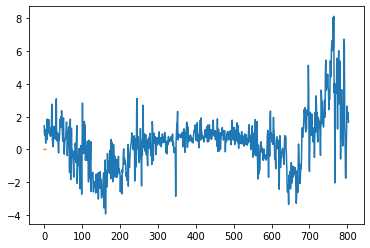

In [71]:
plt.plot(outputs[0,:])

In [73]:
y_train.shape

(804, 5)

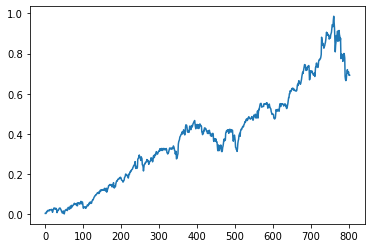

In [81]:
plt.plot(y_train[:,0])